In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter1d as g1d
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from matplotlib import cm


# ISGRI Low Energy Charge Loss

OSA11 charge loss model is fitted to lines at ~60 keV and 511 keV.
Trivial extrapolation of the evolution to 20 keV would lead to clear mismatch with ground calibration lines (applicable early mission) and cross-calibration obsevations (applicable late mission).

At ~22 keV there is a Cd line complex ([see](https://xdb.lbl.gov/Section1/Table_1-2.pdf)), but it's hard to use it due to several effects (in the order from more important to less important):
* low energy cut-off by pixel threshold. This effect appears as shift to high energy. The LE threshold can be only reasonably determined with astrophysical source observations.
* energy resolution. Since since the broadened line is cutoff at low energy, it unequally broadens to high energy. Resolution at LE can only be rather approximately determined with astrophysical source observations.
* underlying background is very variable at low energy, and sensitive to CR-induced activation. Also astrophysical sources brighter than 300 mCrab are comparable to background level, and bias energy estimation depending on the source spectrum, usually to high energy. It is possible to exclude particularly anomalous background conditions, but long-term trends are hard to disentangle from other effects. See [there](https://volodymyrss.github.io/imgb/history.html)

For realistic magnitude of these effects, the shifts may lead to apparent line centroid from 20 to 30 keV, for actual line at 22 keV. See example below.

Below, shown separately background and source rates

<table><tr>
<td><img src="https://volodymyrss.github.io/imgb/detelc_decomposed.png.1406121161.88b8ca491b" width="500px"></td>
<td><img src="https://volodymyrss.github.io/imgb/history.png.1406120164.1771a51d05" width="500px"></td>
</tr></table>

In [94]:
from astropy.io import fits
lut2 = fits.open('/mnt/sshfs/cdcihn/unsaved/astro/savchenk/data/reduced/ddcache/byrev/0239/FinalizeLUT2.xvbase5.2/4711debf/lut2_1d_final.fits.gz')[0]
lut2.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                 2048                                                  
MU_E    =    869.5551914492459                                                  
MU_T    =    57.46021435346341                                                  
TAU_E   = 1.13761700113863E-06                                                  
TAU_T   = 5.96321625870866E-06                                                  
GAIN    =    8.077544426494347                                                  
OFFSET  =   -8.409137047104311                                                  
RT_OFFSE=                    5                                                  
V       =                  1

In [111]:
det_base = bipar_model.detector()

for k in ['mu_e', 'mu_t', 'tau_e', 'tau_t', 'offset']:
    setattr(det_base, k, lut2.header.get(k.upper()))
    
det_base.export_detector()

(869.5551914492459,
 57.46021435346341,
 1.13761700113863e-06,
 5.96321625870866e-06,
 120.0,
 -8.409137047104311)

(1e-05, 10)

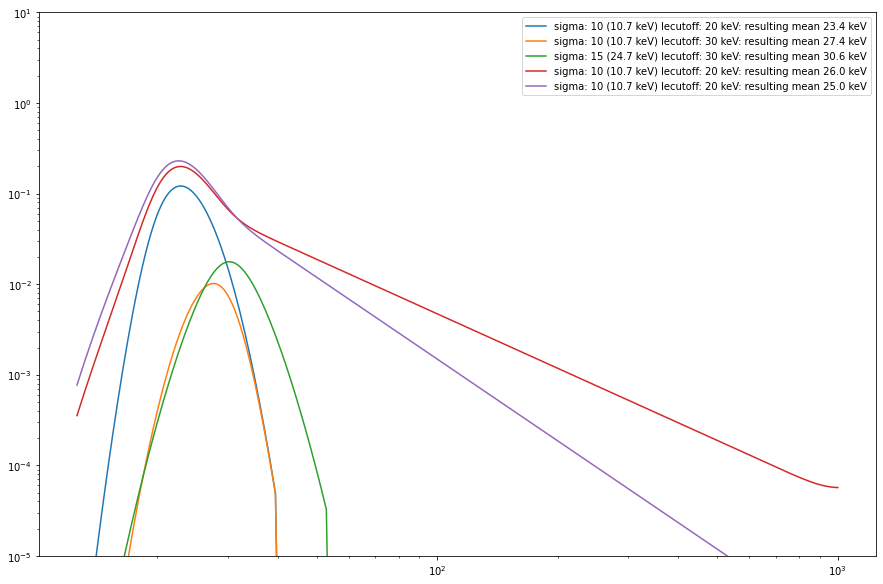

In [ ]:
plt.figure(figsize=(15, 10))

en = np.logspace(1.1, 3, 300)


raw_line = norm(22, 0.1).pdf(en)

def leeffi(en, position=15, sharpness=14):
    return (en/position)**sharpness/(1+(en/position)**sharpness)

def observe(raw, sigma, lecutoff):
    return g1d(raw, sigma)*leeffi(en, lecutoff)


for sigma, lecutoff, extrabkg in [
    (10, 20, 0),
    (10, 30, 0),
    (15, 30, 0),    
    (10, 20, 0.05*(en/30)**-2),
    (10, 20, 0.05*(en/30)**-3),
]:
    m = en < 50
    obs_nole = observe(raw_line, sigma, 0.1)
    obs = observe(raw_line + extrabkg, sigma, lecutoff)

    mean = np.sum((en*obs)[m])/np.sum(obs[m])
    width = np.nansum((obs_nole*en**2)[m])/np.nansum(obs_nole[m]) - (np.nansum((obs_nole*en)[m])/np.nansum(obs_nole[m]))**2

    plt.plot(
        en,
        obs,
        label=f"sigma: {sigma} ({width:.1f} keV) lecutoff: {lecutoff} keV: resulting mean {mean:.1f} keV"
    )



plt.loglog()
plt.legend()

plt.ylim([1e-5, 10])

Text(0, 0.5, 'RT (ISGRI Rise Time channel)')

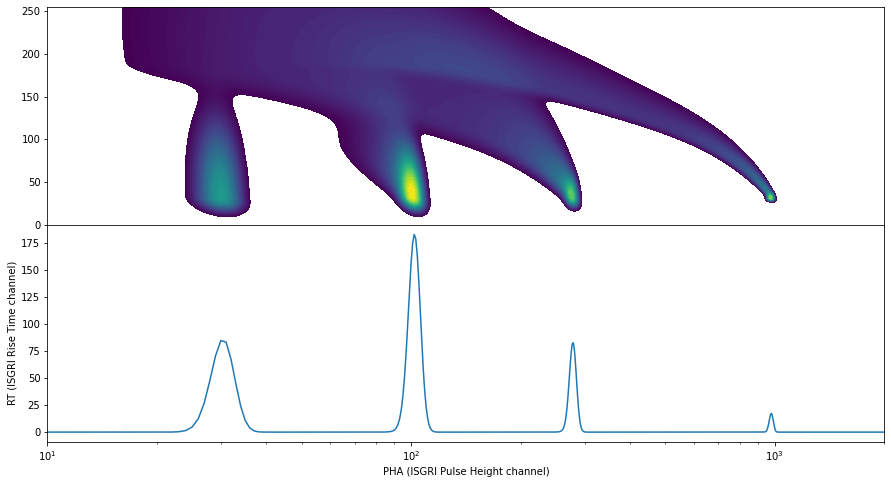

In [112]:
import sys
import os
import numpy as np
import importlib

os.environ['EDDOSA_TOOLS_DIR'] = os.getcwd() + '/eddosa_tools/'

sys.path.insert(0, 'dda-ddosa')
sys.path.insert(0, 'dda-eddosa')
sys.path.insert(0, 'eddosa_tools/fit1d')
sys.path.insert(0, 'lut2model/python')

import lut2model
import bipar_model
import eddosa

lut2model.set_verbosity(0)

#lut2model.render_bipar_m0()

bpm = eddosa.BiparModel()
bpm.bipar_model
det = bipar_model.detector()
det.import_detector(det_base.export_detector())

pha_2d, rt_2d = np.meshgrid(np.arange(2048), np.arange(256))


bip = np.zeros_like(pha_2d, dtype=float)
    
for en in [22, 59, 150, 511]:
    _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()
    
    bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)

f, (ax1,ax2) = plt.subplots(2,1, figsize=(15, 8), sharex=True)
ax1.contourf(pha_2d, rt_2d, bip**0.5, levels=np.logspace(-1, 0)*np.nanmax(bip**0.5))

ax2.plot(
    pha_2d[0,:],
    bip[15:30,:].sum(0)
)

plt.semilogx()
plt.xlim([10, 2000])
plt.subplots_adjust(hspace=0)

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')

#TODO: total event number lost to high RT threshold
#TODO: discontinuities from abs edges

Text(0, 0.5, 'RT (ISGRI Rise Time channel)')

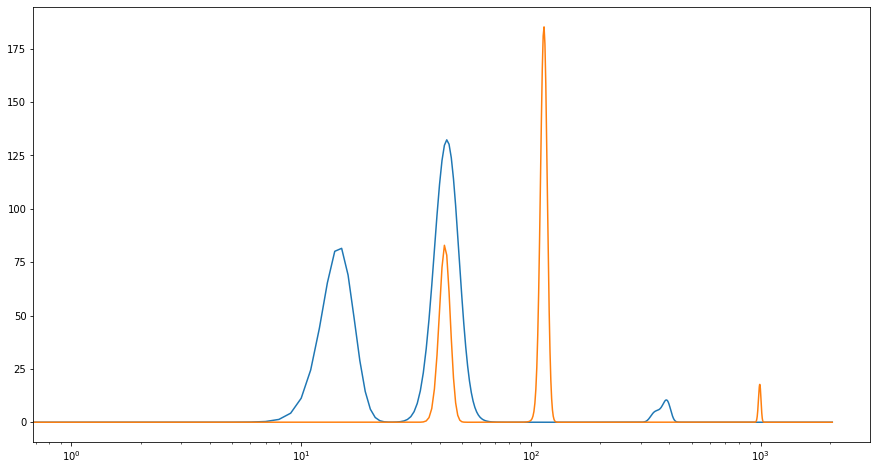

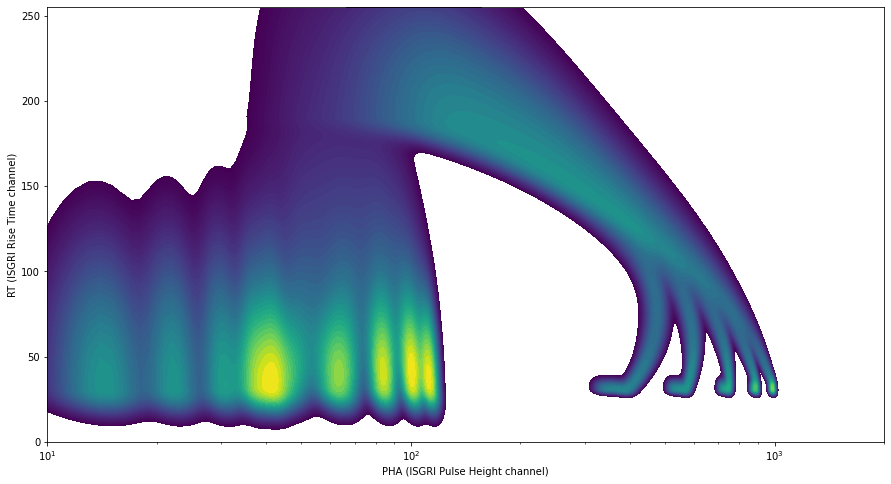

In [113]:
bip = np.zeros_like(pha_2d, dtype=float)

lrt_lines = []

plt.figure(figsize=(15,8))

for i_loss, tau_loss_factor in enumerate(np.logspace(-1., 0, 5)):
    det = bipar_model.detector()
    det.tau_e = det_base.tau_e * tau_loss_factor

    this_loss_bip = np.zeros_like(bip)

    for en in [22, 59, 511]:
        _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()

        for rt1, rt2 in [(15,30), (50,70)]:
            ltr_bip = _bip[rt1:rt2, :].sum(0)
            lrt_lines.append(
                dict(
                    rt1=rt1,
                    rt2=rt2,
                    energy=en,
                    tau_e=det.tau_e,
                    mean_pha=np.sum(pha_2d[0,:]*ltr_bip)/np.sum(ltr_bip),
                    _bip=_bip,
                )
                )
        
        this_loss_bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)
    
    bip += this_loss_bip

    if i_loss % 4 == 0:
        plt.plot(
            pha_2d[0,:],
            this_loss_bip[15:30,:].sum(0)
        )

plt.semilogx()

plt.figure(figsize=(15, 8))
plt.contourf(pha_2d, rt_2d, bip**0.5, levels=np.logspace(-1, 0)*np.nanmax(bip**0.5))

plt.semilogx()
plt.xlim([10, 2000])

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')

# for vl in vlines:
#     plt.axvline(vl)

Charge loss model, in principle, results in a prescription to how low-energy part evolves. This prescription is somewaht different from simple linear change of offset and gain. But not as different as what is observed at low energy.

Prescriptions for evolution at different energies are are shown below.

Text(0, 0.5, 'fraction of PH lost')

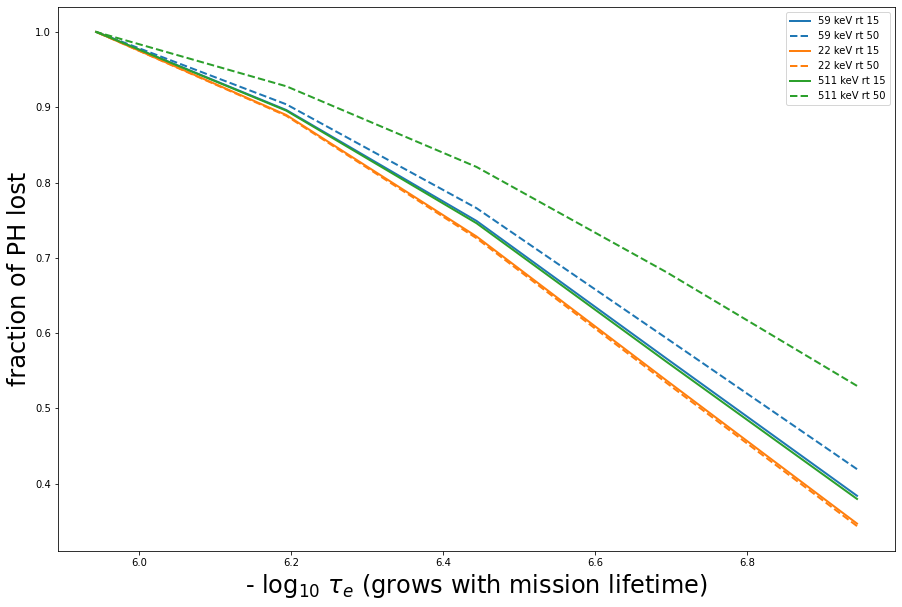

In [114]:
plt.figure(figsize=(15, 10))

for en in set([l['energy'] for l in lrt_lines]):
    c = None
    ls_list=['-','--']
    for rt1 in [15, 50]:
        mean_phas = np.array([l['mean_pha'] for l in lrt_lines if l['energy'] == en and l['rt1'] == rt1])
        c=plt.plot(
            [-np.log10(l['tau_e']) for l in lrt_lines if l['energy'] == en  and l['rt1'] == rt1],
            mean_phas/mean_phas.max(),
            label=f"{en} keV rt {rt1}",
            c=c,
            ls=ls_list.pop(0),
            lw=2
        )[0].get_color()

plt.legend()
#plt.semilogx()
plt.xlabel(r"- log$_{10}~\tau_e$ (grows with mission lifetime)", size=24)
plt.ylabel(r"fraction of PH lost", size=24)

# Detector polarization

As discussed above, assuming no polarization, or uniform polarization does not reproduce low-energy response compatible with observations.

Since detector is always polarized, it's hard to distinguish effect of degradation of charge carrior properties due to irradiation from
polarization. 

Especially if the polarization is inhomogenous. And since polarization effect itself is known to depend on irradiation dose itself, just as charge carried properties do.


Text(0, 0.5, 'RT (ISGRI Rise Time channel)')

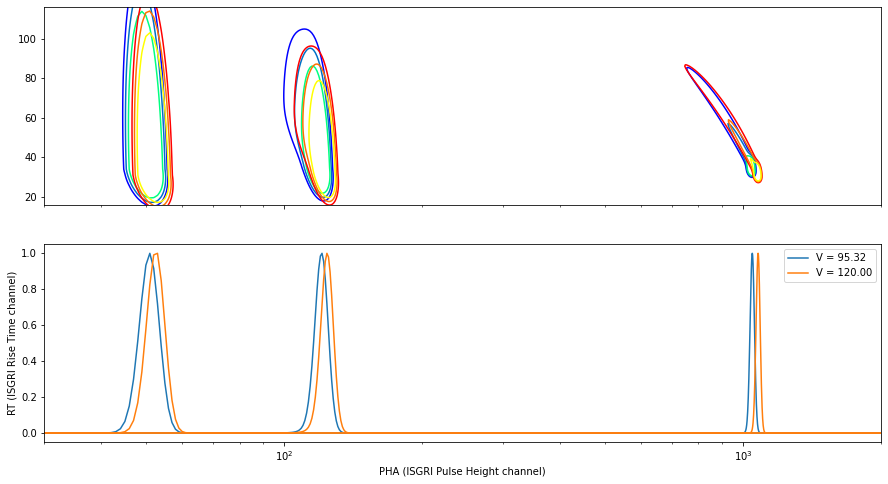

In [152]:
bip = np.zeros_like(pha_2d, dtype=float)

det_base = bipar_model.detector()

lrt_lines = []


f, (ax1,ax2) = plt.subplots(2,1, figsize=(15, 8), sharex=True)

#for tau_loss_factor in np.logspace(-1., 0, 3):
N = 5
for i_loss, V_loss_factor in enumerate(np.logspace(-0.1, 0, N)):
    det = bipar_model.detector()
    #det.tau_e = det_base.tau_e * tau_loss_factor
    det.V = det_base.V * V_loss_factor

    c = None
    label = f"V = {det.V:.2f}"

    for en in [25, 59, 511]:
        _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()

        for rt1, rt2 in [(15,30), (50,70)]:
            ltr_bip = _bip[rt1:rt2, :].sum(0)
            lrt_lines.append(
                dict(
                    rt1=rt1,
                    rt2=rt2,
                    energy=en,
                    tau_e=det.tau_e,
                    V=det.V,
                    mean_pha=np.sum(pha_2d[0,:]*ltr_bip)/np.sum(ltr_bip)
                )
                )
        
        bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)

        if i_loss % (N-1) == 0:
            ax1.contour(pha_2d, rt_2d, _bip**0.5, levels=np.logspace(-0.5, -0.3, 3)*np.nanmax(_bip**0.5),
                        cmap=cmap_by_loss[int(i_loss/(N-1))]
            )
         
            c = ax2.plot(
                pha_2d[0,:],
                _bip[15:30,:].sum(0)/np.nanmax(_bip[15:30,:].sum(0)),
                c=c,
                label=label
            )[0].get_color()
            label = None



#plt.figure(figsize=(15, 8))
#plt.contourf(pha_2d, rt_2d, bip**0.5, levels=np.logspace(-1, 0)*np.nanmax(bip**0.5))

plt.semilogx()
plt.xlim([30, 2000])
ax1.set_ylim([16, 116])

ax2.legend()

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')

# for vl in lrt_lines:
#     plt.axvline(vl['mean_pha'])

(121.23403059165432, 94.08535757525947)

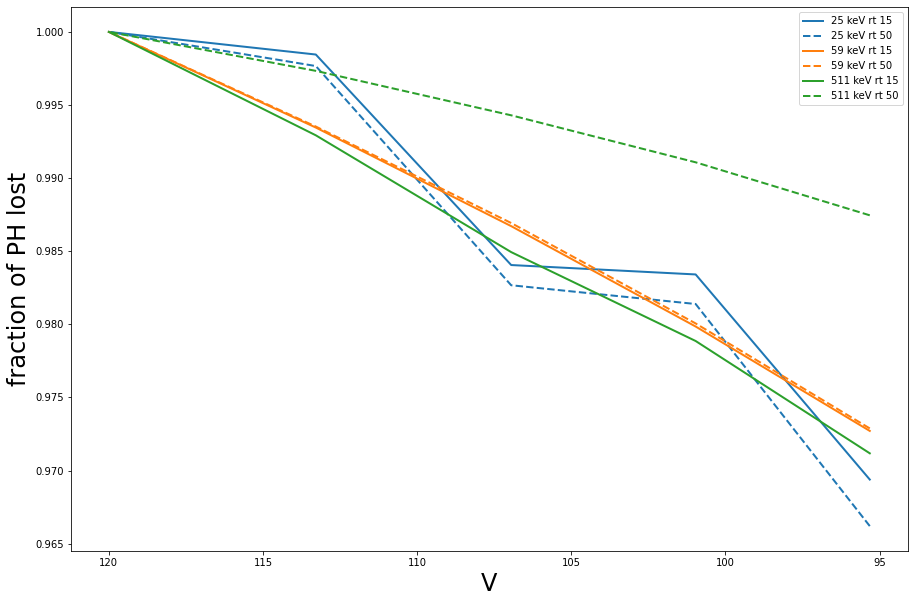

In [153]:
plt.figure(figsize=(15, 10))

for en in set([l['energy'] for l in lrt_lines]):
    c = None
    ls_list=['-','--']
    for rt1 in [15, 50]:
        mean_phas = np.array([l['mean_pha'] for l in lrt_lines if l['energy'] == en and l['rt1'] == rt1])
        c=plt.plot(
            [l['V'] for l in lrt_lines if l['energy'] == en  and l['rt1'] == rt1],
            mean_phas/np.nanmax(mean_phas),
            label=f"{en} keV rt {rt1}",
            c=c,
            ls=ls_list.pop(0),
            lw=2
        )[0].get_color()

plt.legend()
#plt.semilogx()
plt.xlabel(r"V", size=24)
plt.ylabel(r"fraction of PH lost", size=24)

ax=plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

As shown in the picture above, drop of the bias `V` (or, more directly, field `E`) leading to drop in the field in the detector, would cause more rapid loss of gain at low energy than at high energy. Which is the opposite of what is observed. 

So, some other effect is at play, possibly inhomogenous polarization. It is not immediately clear what kind.

Fortunately, polarization can be also observed directly following detector switch-on. It can not be used to give direct prescription for long-term polarization change, but it can give an insight.


# Mismatch between no-polarization model and in-flight source observations

Observations with cyclotron line sources indicate excessive compression of reconstructed energy scale by up to 10% at 30 keV (see [CC-summary](https://gitlab.astro.unige.ch/integral/cc-workflows/cc-global-summary/-/blob/master/verify.ipynb))

Roughly speaking, the model predicts that 30 keV converts PHA=30 to 2021. But we observe that 30 keV converts to PHA=50. #TODO: think again!

It means that charge collection for 30 keV depositions (which, inevitably, all happen near the detector surface, just as 60 keV depositions) remain more efficient than expected, despite substantial loss of electron lifetime, as seen in charge collection for 59 and 511 keV.

#TODO: how is it possible that 60 keV is shifted differently than 30 keV?

* additional unaccounted shift at 511 keV by about XX
* additional unaccounted shift at 59 keV by about XX


When fitting with the model with variable offset by no additional free parameters (no polarization change, for example), this appears as drop in offset.
In principle, offset is expected to be constant.

#TODO: think! 
So the effect is the opposite of what is observed.

* Polarization has the same direction as usual degradation, does not help
* inhomogenous polarization will still affect lRT PHA for LE just as HE lines.

Astro observations seems to suggest that constant offset would work.

#TODO: end-goal here is to show how to:
* enforce constant offset in efficiency, events, response
* centralize response

Text(0, 0.5, 'RT (ISGRI Rise Time channel)')

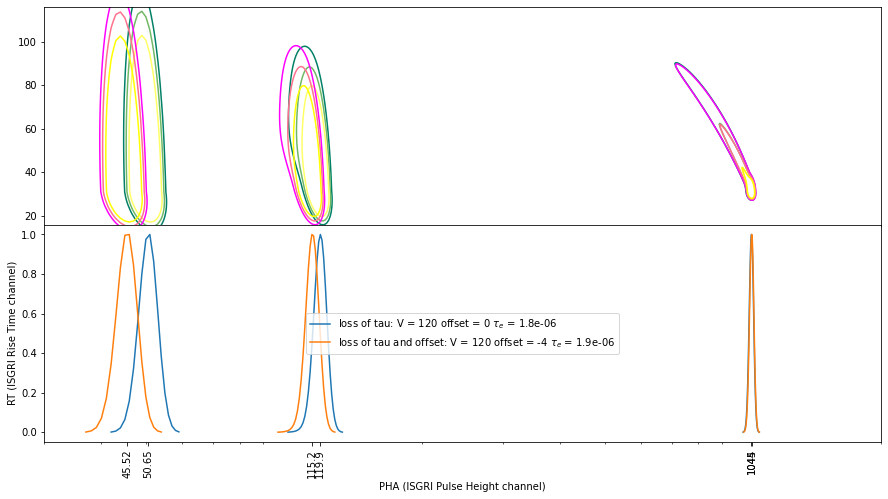

In [148]:
# TODO: measure or mimick gain from HE line alone, and from LE line alone. find which one mismatches


bip = np.zeros_like(pha_2d, dtype=float)

lrt_lines = []

cmap_sequence = [cm.winter, cm.autumn, cm.spring, cm.summer]

f, (ax1,ax2) = plt.subplots(2,1, figsize=(15, 8), sharex=True)

extra_ticks = []

#for tau_loss_factor in np.logspace(-1., 0, 3):
N = 5
for i_loss, (label, V_loss_factor, offset_shift, tau_loss_factor) in enumerate([
            ('loss of tau', 1, 0, 0.65),
            ('loss of tau and offset', 1, -4, 0.7),
            #('loss of V', 0.8, 0, 1),
            #('loss of V and tau', 0.9, 0, 0.9),
            #('offset drop', 1, -4, 1),
        ]):
    det = bipar_model.detector()
    #det.tau_e = det_base.tau_e * tau_loss_factor
    det.V = det_base.V * V_loss_factor
    det.offset = det_base.offset + offset_shift
    det.tau_e = det_base.tau_e * tau_loss_factor

    c = None
    label = f"{label}: V = {det.V:.3g} offset = {det.offset:.3g} $\\tau_e$ = {det.tau_e:.2g}"
    cmap = cmap_sequence.pop()

    for en in [25, 59, 511]:
        _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()

        for rt1, rt2 in [(15,30), (50,70)]:
            ltr_bip = _bip[rt1:rt2, :].sum(0)
            lrt_lines.append(
                dict(
                    rt1=rt1,
                    rt2=rt2,
                    energy=en,
                    tau_e=det.tau_e,
                    V=det.V,
                    mean_pha=np.sum(pha_2d[0,:]*ltr_bip)/np.sum(ltr_bip)
                )
                )
        
        bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)

        if i_loss % (N-1) == 0 or True:
            ax1.contour(pha_2d, rt_2d, _bip**0.5, levels=np.logspace(-0.5, -0.3, 3)*np.nanmax(_bip**0.5),
                        cmap=cmap
            )
         
            sp = _bip[15:30,:].sum(0)/np.nanmax(_bip[15:30,:].sum(0))
            m = sp > np.nanmax(sp)/1e3
            c = ax2.plot(
                pha_2d[0,:][m],
                sp[m],
                c=c,
                label=label
            )[0].get_color()
            label = None

            extra_ticks.append(
                np.sum(pha_2d[0,:][m]*sp[m])/np.sum(sp[m])
            )




#plt.figure(figsize=(15, 8))
#plt.contourf(pha_2d, rt_2d, bip**0.5, levels=np.logspace(-1, 0)*np.nanmax(bip**0.5))

plt.semilogx()

#ax2.set_xticks(list(ax2.get_xticks()) + extra_ticks)
ax2.set_xticks(extra_ticks)
#ax2.set_xticklabels(list(ax2.get_xticklabels()) + [str(t) for t in extra_ticks])
ax2.set_xticklabels([f"{t:.4g}" for t in ax2.get_xticks()], rotation='vertical')


plt.xlim([30, 2000])
ax1.set_ylim([16, 116])

ax2.legend()

plt.subplots_adjust(hspace=0)

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')




# for vl in lrt_lines:
#     plt.axvline(vl['mean_pha'])

In [ ]:
# TODO: measure or mimick gain from HE line alone, and from LE line alone. find which one mismatches

# TODO:
# * reconstruct with det
# * reconstruct with det and morph

# TODO: 
# reconstruct effi
# reconstruct lut2
# reconstruct rsp



# Intra-revolution polarization

Polarization develops after detector switch-on. It is not guaranteed that at the revolution start the detector is completely unpolarized. This usually happens at the revolution start, but may also happen in the middle of the revolution, e.g. following IREM reset. 
Short off-time cases partial recovery of the gain. Longer off-time recovers the gain to the same state at which it was before. The fact that some basic level is recovered after some hours, indicates that some stationary state exists and is observed at the beginning of the orbit. It is still not certain if this state is completely unpolarized.

After about 2 days (near the orbit end) the evolution typically stops. This indicates that a new stationary state is reached. It is not reached in all orbits, and this effect also evolves with mission lifetime.

<img src="https://volodymyrss.github.io/imgb/lines_rev.png.1422363474.f83d1aa7f1" height="400px">

Polarization affects high-RT and low-RT data differently as polarization progresses after switch-on:
* low-RT transport is progressively degraded (by about 2%)
* high-RT transport is progressively improved (by about 2%)

<img src="https://volodymyrss.github.io/imgb/rtevo665.png.1438160162.7256945645" height="400px">

This can be also seen in the PHA-RT diagram (left: in the beginning of the revoluion, right: near the end):

<img src="https://volodymyrss.github.io/imgb/early_late_bipar.jpeg.1422893544.c96ba39f09" height="400px">



Normally, high-RT counts correspond to high-depth interactions.
Change in field inevitably affects both RT and PHA. 

2% decrease in low-RT charge collection corresponds to about 2% change in field. # check???

Text(0, 0.5, 'RT (ISGRI Rise Time channel)')

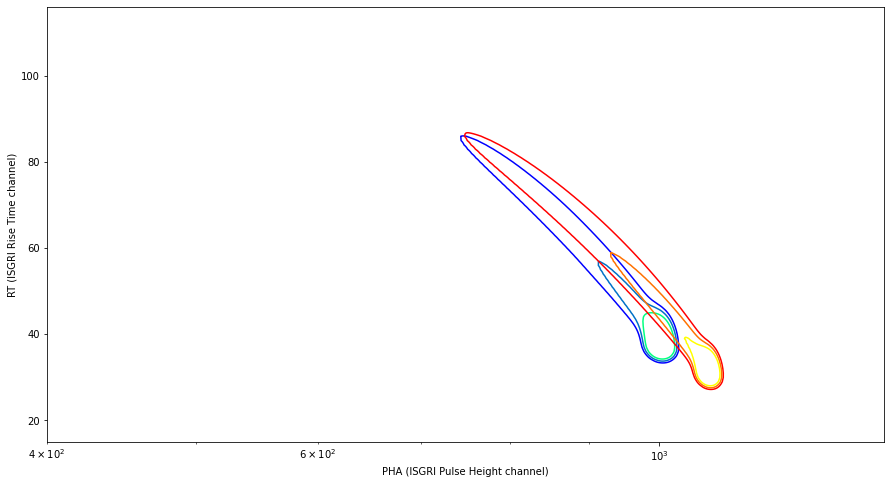

In [82]:
bip = np.zeros_like(pha_2d, dtype=float)

det_base = bipar_model.detector()

lrt_lines = []

plt.figure(figsize=(15, 8))

cmap_by_loss = {
    0: cm.winter,
    1: cm.autumn
}


#for tau_loss_factor in np.logspace(-1., 0, 3):
for i_loss, V_loss_factor in enumerate(np.logspace(-0.2, 0, 2)):
    det = bipar_model.detector()
    #det.tau_e = det_base.tau_e * tau_loss_factor
    det.V = det_base.V * V_loss_factor

    #for en in [511]:
    for en in [59, 511]:
        _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()

        for rt1, rt2 in [(15,30), (50,70)]:
            ltr_bip = _bip[rt1:rt2, :].sum(0)
            lrt_lines.append(
                dict(
                    rt1=rt1,
                    rt2=rt2,
                    energy=en,
                    tau_e=det.tau_e,
                    V=det.V,
                    mean_pha=np.sum(pha_2d[0,:]*ltr_bip)/np.sum(ltr_bip),
                    bip=_bip
                )
                )
        
        bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)


        plt.contour(pha_2d, rt_2d, _bip**0.5, levels=np.logspace(-0.5, -0.3, 3)*np.nanmax(_bip**0.5),
                    cmap=cmap_by_loss[i_loss]
        )

plt.semilogx()
plt.xlim([400, 1400])
#plt.xlim([70, 1200])
plt.ylim([15, 116])

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')

# for vl in lrt_lines:
#     plt.axvline(vl['mean_pha'])

/tmp/ipykernel_421266/4224400571.py:9: RuntimeWarning: invalid value encountered in true_divide
  pha = (_bip*pha_2d).sum(1)/_bip.sum(1)


(15.0, 116.0)

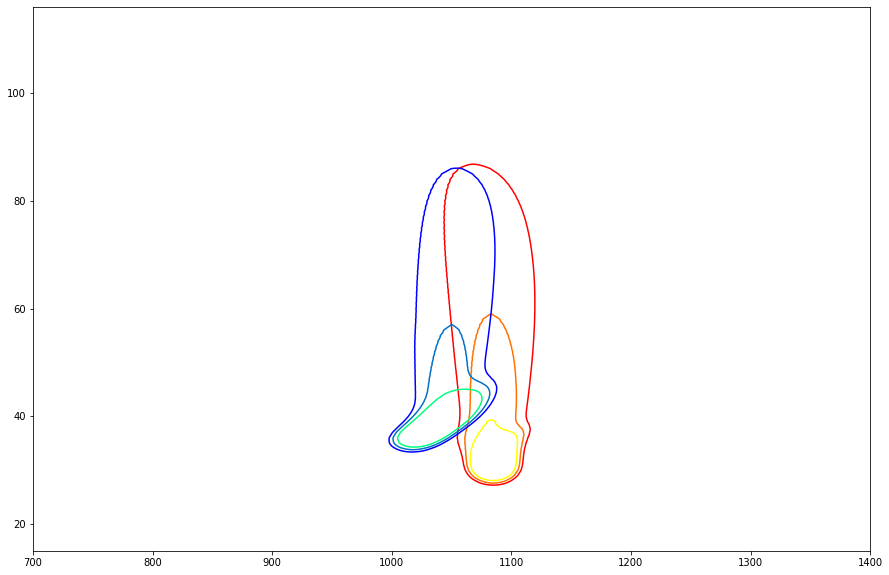

In [28]:
plt.figure(figsize=(15,10))

for pair in [[lrt_lines[-1]['bip'], lrt_lines[-6]['bip']],
             [lrt_lines[0]['bip'], lrt_lines[4]['bip']]]:
    cmaps = [cm.winter, cm.autumn]*4
    _bip = pair[0]

    rt = rt_2d[:,0]
    pha = (_bip*pha_2d).sum(1)/_bip.sum(1)
    m = ~np.isnan(pha)
    lut2 = interp1d(rt[m], pha[m]/np.nanmax(pha), bounds_error=False)

    for _bip in pair:
        plt.contour(pha_2d/np.outer(lut2(rt), np.ones(2048)), rt_2d, _bip**0.5, levels=np.logspace(-0.5, -0.3, 3)*np.nanmax(_bip**0.5),
                    cmap=cmaps.pop())


plt.xlim([700, 1400])
plt.ylim([15, 116])

#plt.xlabel()

#plt.semilogx()





There are not many ways to explain this. The best I can suggest for now is changes in detector homogenuity: polarization and/or charge carrier properties.

#TODO: combine and estimate field and detector properties inhomegenuity effect
#TODO: model field inhomogenuity to see what it does?

* In particular, it does not appear possible to achieve improvement in the high-RT collection in this way.
The tracks can never cross. An idea to achieve this was by stretiching the RT, which goes part of the way, but not enough.
* The RT shift at low RT is incompatible with observations

Inhomogenous field may be used to explain it.

Specifically, increase of field at higher depth and decrease at lower depth might produce the desired effects.


#  Effects of offset

ISGRI has negative offset.

Since, as explained above, it is not easy to characterize EN-PHA conversion at low energy,

the calibration line evolution as observed indicates

In [ ]:
#TODO: deduce gain evolution just from the first line, assuming constant offset.
#TODO: reconstruction with mismatching detector configurations